# Face Re-Identification Protocol on Ethereum Blockchain

## Imports

In [14]:
import keras
from keras.preprocessing import image
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json
import time
import subprocess
from resnetBioHashModel import preprocess_input
from BioHash import connect2IPFS, train_model, generate_biohash, loadFaceModelFeaturesOnly
from BioHash import compare_biohash, train_fingerprint_model, compare_biohashEuclidianDistance
from BioHash import save_vectors_ipfs, retriveIPFSHashContent, getIPFSHashFile, findCosineSimilarity
from web3 import Web3, HTTPProvider, IPCProvider, WebsocketProvider


# IPFS SETUP

In [2]:
#Running Daemon
import os
os.system("ipfs daemon &")
time.sleep(5)
IPFS_Host = "127.0.0.1"
IPFS_Port = 5001
connect2IPFS(IPFS_Host, IPFS_Port)


Successful connected to IPFS nectwork


## Load Sample Pictures

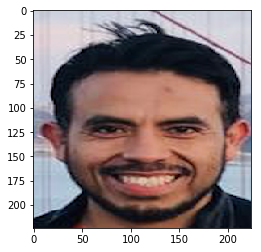

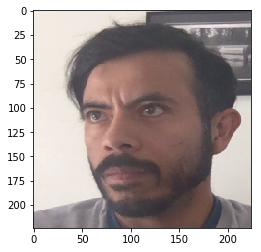

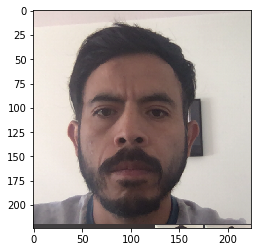

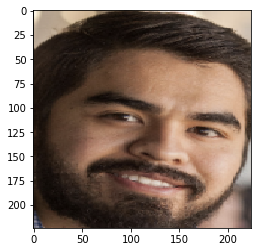

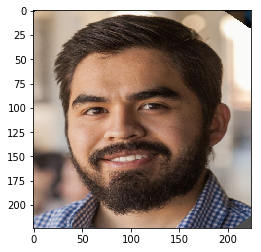

In [3]:
image1 = image.load_img('image/beto1.jpg', target_size=(224, 224))
image2 = image.load_img('image/beto2.jpg', target_size=(224, 224))
image3 = image.load_img('image/beto3.png', target_size=(224, 224))
image4 = image.load_img('image/angel1.png', target_size=(224, 224))
image5 = image.load_img('image/angel2.png', target_size=(224, 224))
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()
plt.imshow(image4)
plt.show()
plt.imshow(image5)
plt.show()

# FEATURE EXTRACTION

In [4]:
model = loadFaceModelFeaturesOnly()

def extractFeatures(img):
    #pre-process
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, version=2)
    img_representation = model.predict(x).ravel()
    return img_representation
    
representation1 = extractFeatures(image1)
representation2 = extractFeatures(image2)
representation3 = extractFeatures(image3)
representation4 = extractFeatures(image4)
representation5 = extractFeatures(image5)


In [5]:
print(representation2)

[0.         0.05221172 6.3419924  ... 0.         0.63432634 0.        ]


## GENERATE HASH & Store on IPFS NETWORK the Vector Representation

In [6]:
biohash1 = save_vectors_ipfs(representation1)
print(biohash1)
biohash2 = save_vectors_ipfs(representation2)
print(biohash2)
biohash3 = save_vectors_ipfs(representation3)
print(biohash3)
biohash4 = save_vectors_ipfs(representation4)
print(biohash4)
biohash5 = save_vectors_ipfs(representation5)
print(biohash5)


{'Name': '81b57f947ff48c09a55338787927ba88.npy', 'Hash': 'QmdShNxsjxi9zxh7qGnGZTKTPGPfgrndu1R4TztAEKLzhg', 'Size': '8331'}
QmdShNxsjxi9zxh7qGnGZTKTPGPfgrndu1R4TztAEKLzhg
{'Name': 'ec7593dc99d51b2ce775991df52212de.npy', 'Hash': 'QmRzgETwo7uhnW2hS8BagrivnztdZNwduLWnWACz9ENCD1', 'Size': '8331'}
QmRzgETwo7uhnW2hS8BagrivnztdZNwduLWnWACz9ENCD1
{'Name': 'e301229780b36097cb5295b96790f431.npy', 'Hash': 'QmUWnqpoXpx6EAv48xpGAxmWTF3fA3TesFHsUC5B9iQ4L2', 'Size': '8331'}
QmUWnqpoXpx6EAv48xpGAxmWTF3fA3TesFHsUC5B9iQ4L2
{'Name': 'e019c3ed70f4c3528836b183744c9033.npy', 'Hash': 'QmYytXtwAPNiV3LsPAuLRuUogCVp9keu5UvT3RsRbvv2Qp', 'Size': '8331'}
QmYytXtwAPNiV3LsPAuLRuUogCVp9keu5UvT3RsRbvv2Qp
{'Name': 'b4291e8d4c86e14e69197ace9d42efc8.npy', 'Hash': 'QmXZNLNjwi4Qj91VoBByGUfcXFk8RDHLCtYHnofdTW2Khs', 'Size': '8331'}
QmXZNLNjwi4Qj91VoBByGUfcXFk8RDHLCtYHnofdTW2Khs


In [9]:
print(biohash2)

QmRzgETwo7uhnW2hS8BagrivnztdZNwduLWnWACz9ENCD1
[0.         0.05221172 6.3419924  ... 0.         0.63432634 0.        ]


## Connect to ETH SmartContract

In [11]:

web3 = Web3(HTTPProvider('https://rinkeby.infura.io'))
contractAddress='0x61d239d319877005ccd69407a116c891493ca9cc'
wallet_private_key   = '8B3BB16F191526F41EE81984A2719703C20EC16DA7D11359F5440D3C6DEAA8B0'
wallet_address       = '0xd17d17c5e6492ec0a087b9e7BadB6a18Cdf47225'

dbAddress = web3.toChecksumAddress(contractAddress)
with open("BioHashComparation.abi.js") as f:
    info_json = json.load(f)
abi = info_json

myContract = web3.eth.contract(address=dbAddress, abi=abi)
print(myContract)



Contract URL 
https://rinkeby.etherscan.io/address/0x61d239d319877005ccd69407a116c891493ca9cc

## Execute the SmartContract & Store Hash1 & Hash2 in to the Blockchain 

In [12]:
hash1 = biohash1
hash2 = biohash2
#account
nonce = web3.eth.getTransactionCount(wallet_address)

txn_dict = myContract.functions.storeBioHashRequest(hash1, hash2, False).buildTransaction({
        'gas': 1470000,
        'gasPrice': web3.toWei('400', 'gwei'),
        'nonce': nonce,
    })

signed_txn = web3.eth.account.signTransaction(txn_dict, private_key=wallet_private_key)
result = web3.eth.sendRawTransaction(signed_txn.rawTransaction)
tx_receipt = web3.eth.getTransactionReceipt(result)

while tx_receipt is None:
    time.sleep(2)
    tx_receipt = web3.eth.getTransactionReceipt(result)

print(tx_receipt)


AttributeDict({'blockHash': HexBytes('0x99d99fd31d827b50089e984240ddd02634b977c3c9cf6b3f43a5734a8d1b3a66'), 'blockNumber': 3755307, 'contractAddress': None, 'cumulativeGasUsed': 202858, 'from': '0xd17d17c5e6492ec0a087b9e7badb6a18cdf47225', 'gasUsed': 202858, 'logs': [AttributeDict({'address': '0x61D239D319877005Ccd69407A116c891493CA9cc', 'blockHash': HexBytes('0x99d99fd31d827b50089e984240ddd02634b977c3c9cf6b3f43a5734a8d1b3a66'), 'blockNumber': 3755307, 'data': '0x000000000000000000000000000000000000000000000000000000000000008000000000000000000000000000000000000000000000000000000000000000e000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000002e516d6453684e78736a7869397a78683771476e475a544b545047506667726e6475315234547a7441454b4c7a6867000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002e516d527a674554776f37

## Compare Hash1 vs Hash2 on the Blockchain

In [15]:

request = myContract.events.HashMatchingRequested().processReceipt(tx_receipt)
biohashOriginal = request[0]['args']['biohashOriginal']
biohashToCompare =  request[0]['args']['biohashToCompare']
isFingerprint = request[0]['args']['isFingerprint']
idTransaction = request[0]['args']['idTransaction']
print("biohashOriginal:", biohashOriginal)
print("biohashToCompare:", biohashToCompare)
print("isFingerprint: ", isFingerprint)
print("idTransaction: ", idTransaction)

getIPFSHashFile(biohashOriginal)
getIPFSHashFile(biohashToCompare)
time.sleep(1)
features1 = np.load(biohashOriginal)
features2 = np.load(biohashToCompare)

print(features1) 
print(features2) 

epsilon = 0.41
cosine_similarity = findCosineSimilarity(features1, features2)
faceMatch = False
print("cosine_similarity: ", cosine_similarity)
if(cosine_similarity < epsilon):
    print("##########################")
    print("Succesful Match ")
    faceMatch = True
else:
    print("#########################")
    print("Did not Match ")
    faceMatch = False

biohashOriginal: QmdShNxsjxi9zxh7qGnGZTKTPGPfgrndu1R4TztAEKLzhg
biohashToCompare: QmRzgETwo7uhnW2hS8BagrivnztdZNwduLWnWACz9ENCD1
isFingerprint:  False
idTransaction:  2
[ 0.        0.       11.994291 ...  0.        0.        0.      ]
[0.         0.05221172 6.3419924  ... 0.         0.63432634 0.        ]
cosine_similarity:  0.40945982933044434
Succesful Match 


## Store the Match result on the Blockchain


In [16]:
nonce = web3.eth.getTransactionCount(wallet_address)

txn_dict = myContract.functions.updateBioHashComparationResult(idTransaction, faceMatch).buildTransaction({
        'gas': 1470000,
        'gasPrice': web3.toWei('400', 'gwei'),
        'nonce': nonce,
    })

signed_txn = web3.eth.account.signTransaction(txn_dict, private_key=wallet_private_key)
result = web3.eth.sendRawTransaction(signed_txn.rawTransaction)
tx_receipt = web3.eth.getTransactionReceipt(result)

while tx_receipt is None:
    time.sleep(2)
    tx_receipt = web3.eth.getTransactionReceipt(result)

print(tx_receipt)

AttributeDict({'blockHash': HexBytes('0xa2121bb26f28b29cbcb8b8b54bdc66d26b73b6e7db44872db7409583cd90f3e2'), 'blockNumber': 3755370, 'contractAddress': None, 'cumulativeGasUsed': 44337, 'from': '0xd17d17c5e6492ec0a087b9e7badb6a18cdf47225', 'gasUsed': 44337, 'logs': [AttributeDict({'address': '0x61D239D319877005Ccd69407A116c891493CA9cc', 'blockHash': HexBytes('0xa2121bb26f28b29cbcb8b8b54bdc66d26b73b6e7db44872db7409583cd90f3e2'), 'blockNumber': 3755370, 'data': '0x00000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000001', 'logIndex': 0, 'removed': False, 'topics': [HexBytes('0xd9dbf69cba8a74ae349ddf8257e19423106ae6b81652bbc69ea3148a44e0f45b')], 'transactionHash': HexBytes('0xba5090f7085b96b85d3e9064b7a8b4789a7949e35fbdb119f1cdf7e7c6f3295d'), 'transactionIndex': 0})], 'logsBloom': HexBytes('0x00080000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000